In [1]:
import torch
import numpy as np

import sys
import matplotlib.pyplot as plt

sys.path.append('../')

from dynamics import*
from utils import*
from _DeepPrior4DVar import*

# Load data

In [2]:
root_dir='../data/generated/'
i=32
T=10
subsample=3

initial_condition=np.load(root_dir+'initial_conditions/'+
                          '{0:04}'.format(int(i))+'.npy')
Obs=np.load(root_dir+'Obs/'
                          +'{0:04}'.format(int(i))+'.npy')

Rm1=torch.ones(Obs.shape)*(Obs!=0)

# Plot

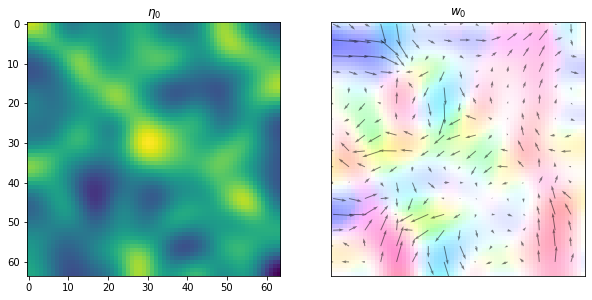

In [27]:
# Ground truth initial conditions
eta0_truth=initial_condition[0,:,:]
w0_truth=torch.Tensor(initial_condition[1:,:,:])

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(eta0_truth)
plt.title('$\eta_{0}$')
plt.subplot(1,2,2)
plot_w(w0_truth[0,:,:], w0_truth[1,:,:], quiver=True, title='$w_{0}$', q_scale=2.5)
plt.show()

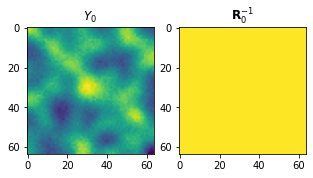

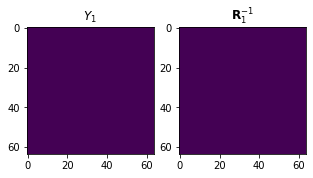

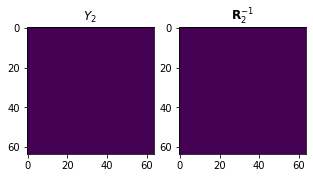

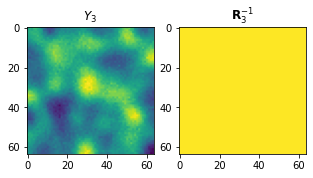

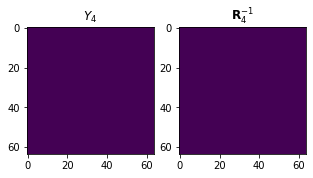

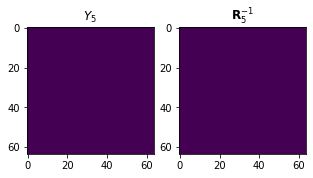

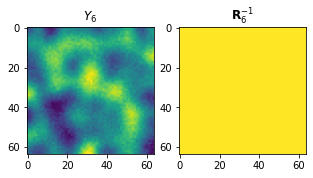

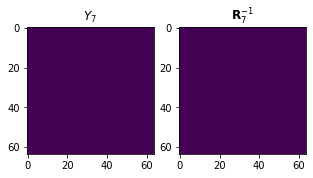

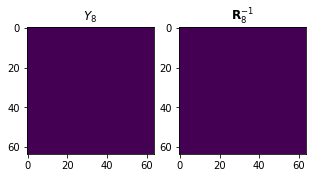

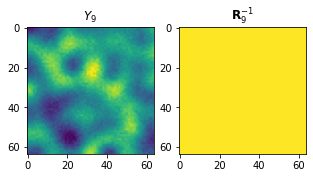

In [5]:
# Observations and associated variance
for t in range(10):
    
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(Obs[t,0,:,:])
    plt.title('$Y_'+str(t)+'$')
    plt.subplot(1,2,2)
    plt.imshow(Rm1[t,0,:,:],vmin=0,vmax=1)
    plt.title('$\mathbf{R}^{-1}_'+str(t)+'$')
    plt.show()

In [6]:
dynamics=SW(dx,dy)
Obs=torch.Tensor(Obs)
Rm1=torch.Tensor(Rm1)

# Deep Prior 4D-Var - settings

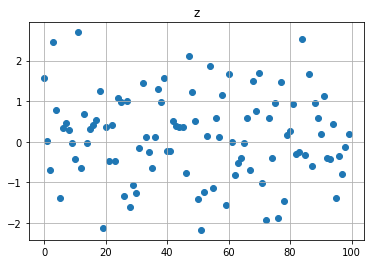

In [7]:
# Size of z latent vector (i.e. size of generator input)
nz = 100
noise = torch.randn(nz, 1, 1)
plt.scatter(range(len(noise)),noise)
plt.grid()
plt.title('z')
plt.show()

In [8]:
# Generator used as deep prior
netG=Generator()
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Upsample(scale_factor=2.0, mode=bilinear)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Upsample(scale_factor=2.0, mode=bilinear)
    (9): ReflectionPad2d((1, 1, 1, 1))
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Upsample(scale_factor=2.0, mode=bilinear)
    (14): ReflectionPad2d((1, 1, 1, 1))
    (15): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (16): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

/Users/arthur_lip6/Library/Python/3.7/lib/python/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([3, 64, 64])


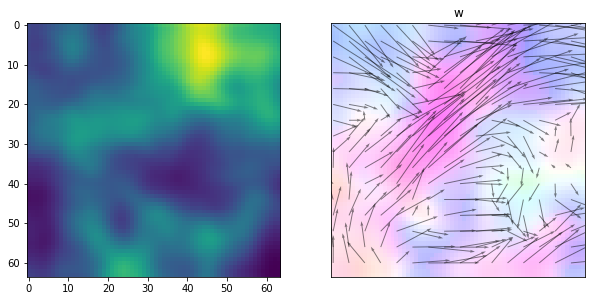

In [9]:
#output of the initialized network

ic_gen=netG((noise).unsqueeze(0)).squeeze(0)
ic_gen=ic_gen.detach()
print(ic_gen.shape)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow((ic_gen)[0,:,:])
plt.subplot(1,2,2)
plot_w(ic_gen[1,:,:],ic_gen[2,:,:],quiver=True,title='w',q_scale=2.5)
plt.show()

# Deep Prior 4D-Var - optimization

/Users/arthur_lip6/Library/Python/3.7/lib/python/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


iter 0


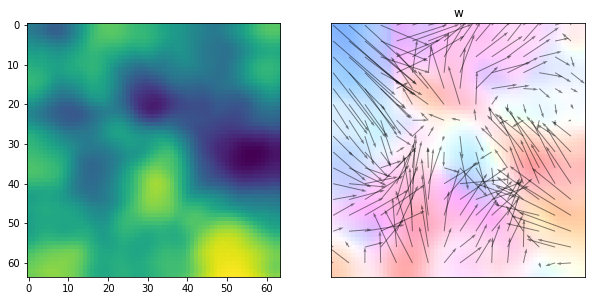

0
3
4
5
6
7
8
10
11
12
13
14
15
21
32
33
34
35
36
37
38
39
40
49
50
65
66
67
68
69
70
98
99
iter 100


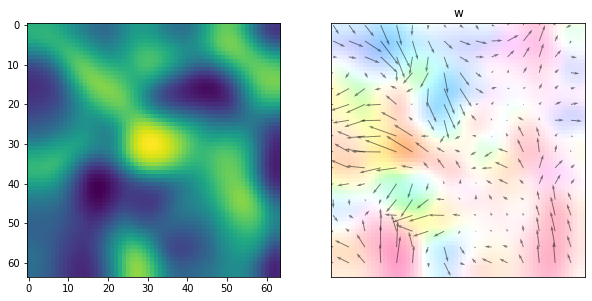

100
114
115
116
117
118
140
141
161
162
172
173
174
195
196
197
iter 200


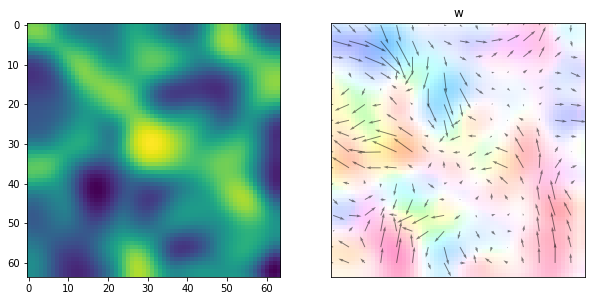

221
222
223
235
289
290
291
292
iter 300


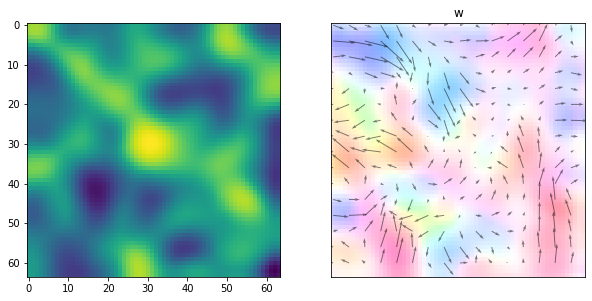

333
334
357
358
iter 400


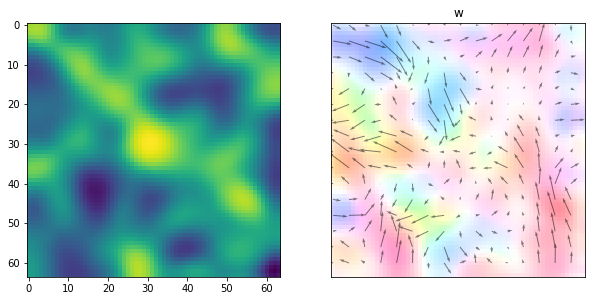

402
403
404
iter 500


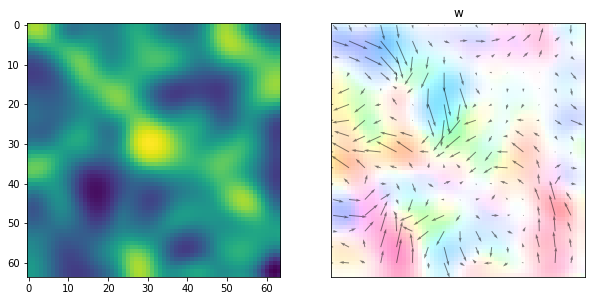

iter 600


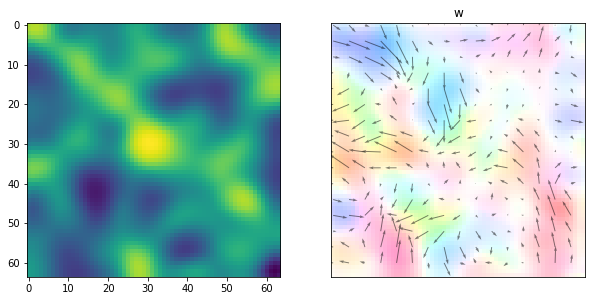

iter 700


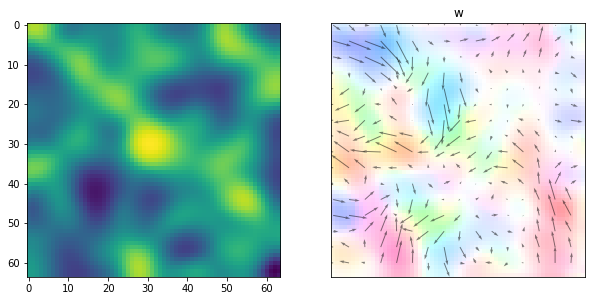

721
722
789
790
iter 800


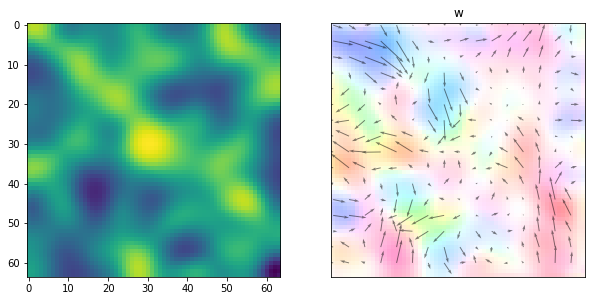

iter 900


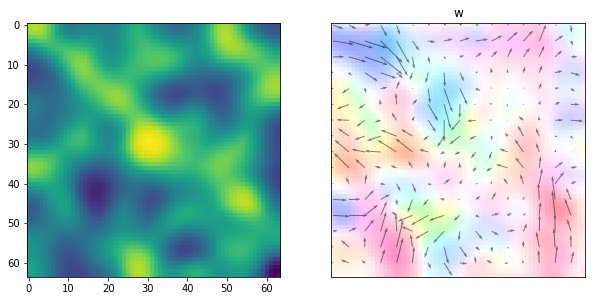

iter 1000


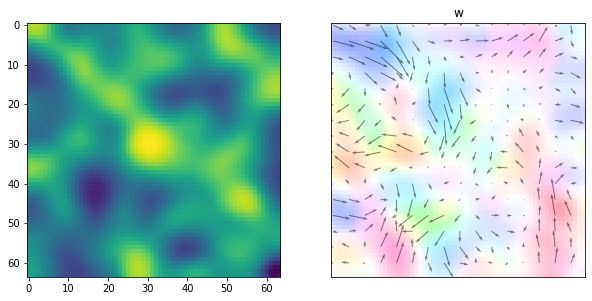

iter 1100


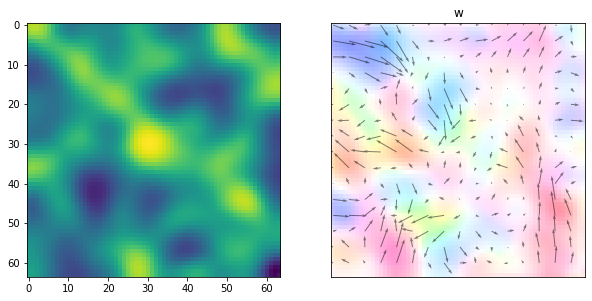

iter 1200


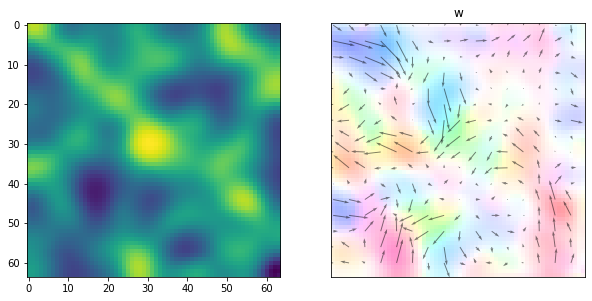

iter 1300


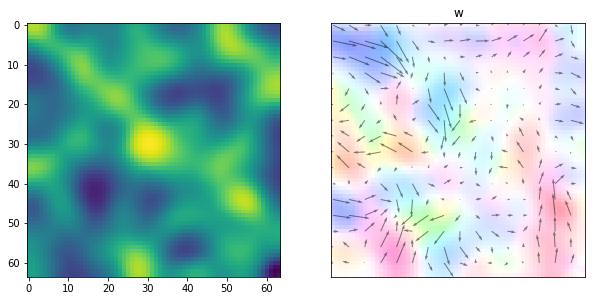

1356
1357
1358
iter 1400


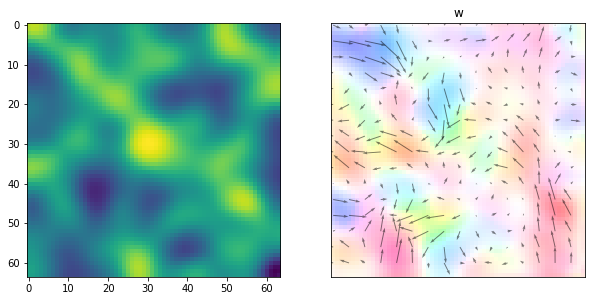

iter 1500


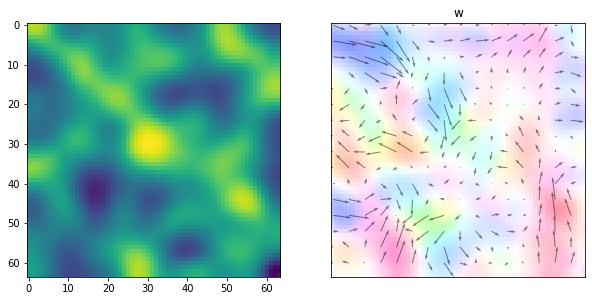

1539
1540
iter 1600


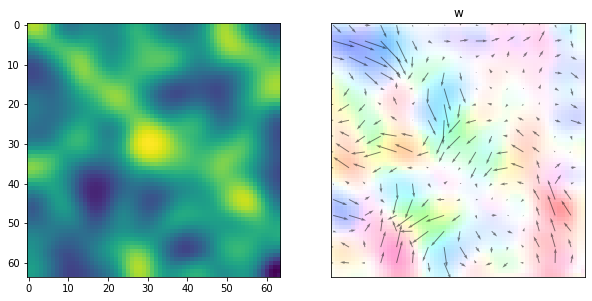

1660
1661
1662
1663
1664
iter 1700


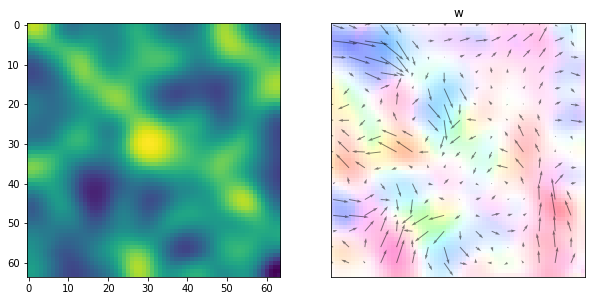

iter 1800


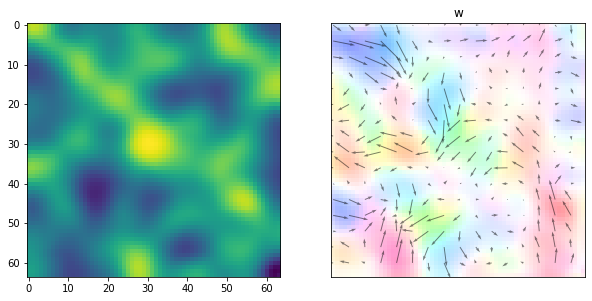

iter 1900


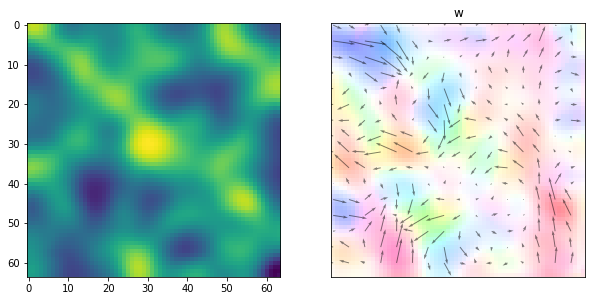

iter 2000


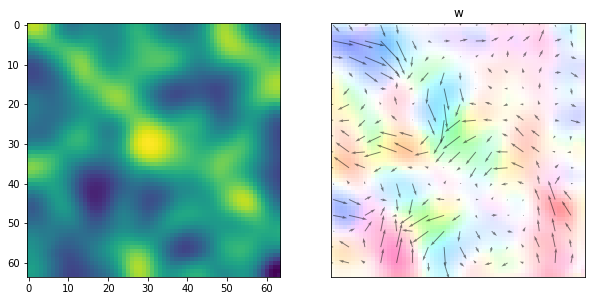

iter 2100


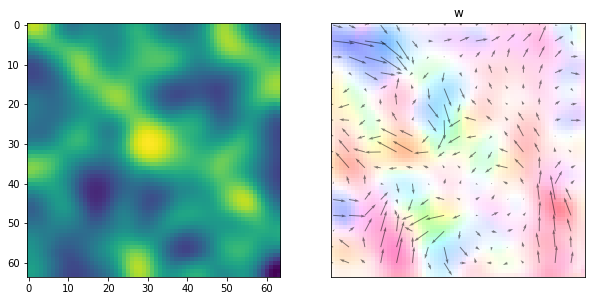

iter 2200


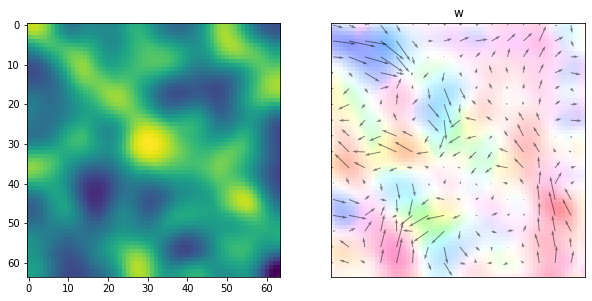

iter 2300


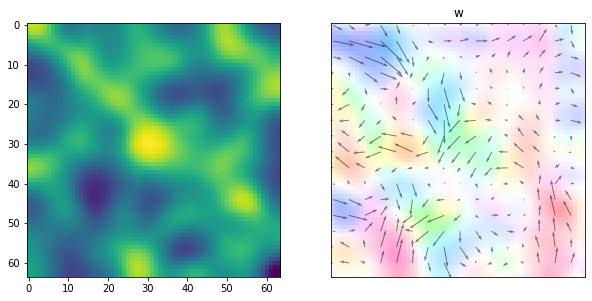

iter 2400


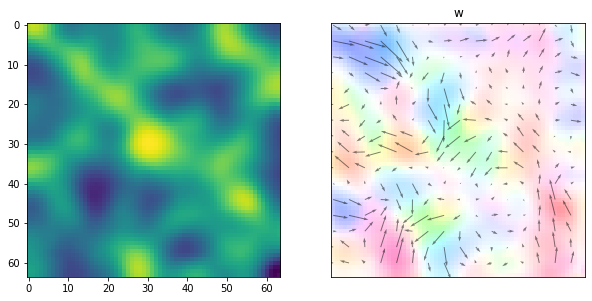

iter 2500


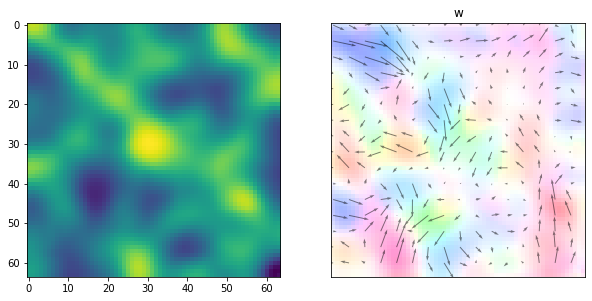

2564
2565
2566
2567
2568
iter 2600


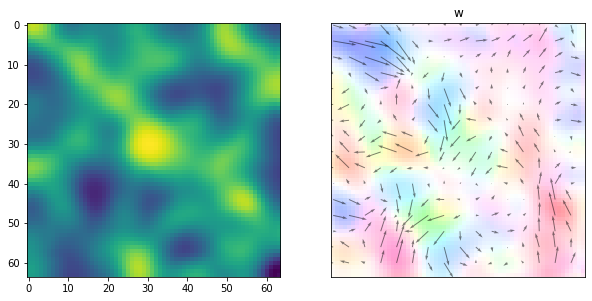

iter 2700


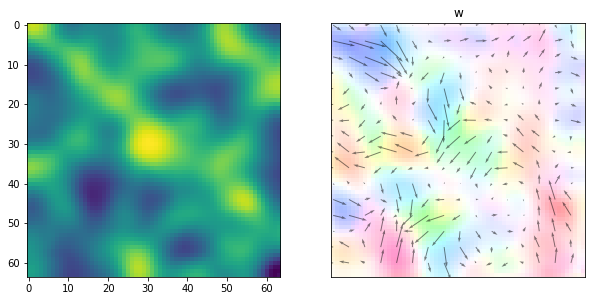

iter 2800


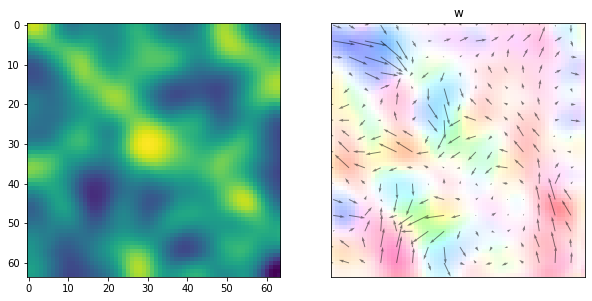

iter 2900


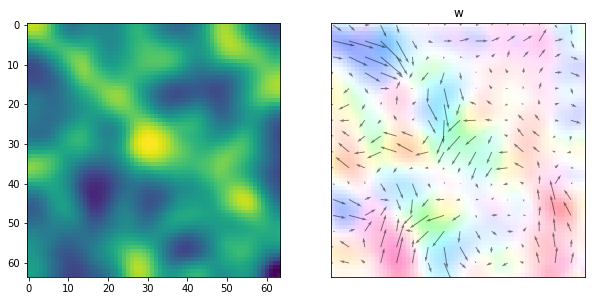

In [20]:
# Learning rate for optimizers
lr = 0.002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Generator
netG = Generator()
# initialize generator weights
netG.apply(weights_init)

def J_obs(X, Rm1, Obs):
    
        # Quadratic observational error
        j = ((Obs-X)*Rm1*(Obs-X)).mean()
        
        # vanish
        #j = j*(((Rm1==Rm1).sum().item()/Rm1!=0).sum().item())
    
        return j
    
epoch=3000

netG = Generator()
netG.apply(weights_init)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

X=torch.zeros(Obs.shape)
losses=[]

for i in range(epoch):
    
    netG.zero_grad()
    loss=0
    ic_gen=netG((noise).unsqueeze(0)).squeeze(0)
    
    if i%100==0:
        print('iter',i)
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow((ic_gen.detach())[0,:,:])
        plt.subplot(1,2,2)
        plot_w(ic_gen.detach()[1,:,:],ic_gen.detach()[2,:,:],quiver=True,title='w',q_scale=2.5)
        plt.show()
        
    
    X=torch.zeros(Obs.shape)
    X[0,:,:,:]=ic_gen
    
    for t in range(T-1):
            
        X[t+1,:,:,:]=dynamics.forward(X[t,:,:,:].clone())
        
    loss=J_obs(X, Rm1, Obs)
    losses.append(loss.item())
    
    #keep the generated initial condition minimizing loss
    if loss.item()==min(losses):
        print(i)
        eta0_deep=ic_gen.detach()[0,:,:]
        w0_deep=ic_gen.detach()[1:,:,:]
        
    loss.backward(retain_graph=True)
    optimizerG.step()

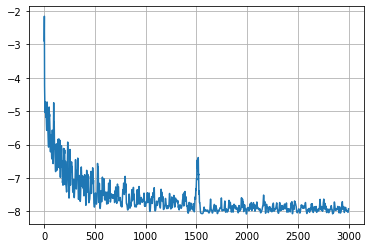

In [16]:
#log scale loss
plt.plot(np.log(np.array(losses)))
plt.grid()

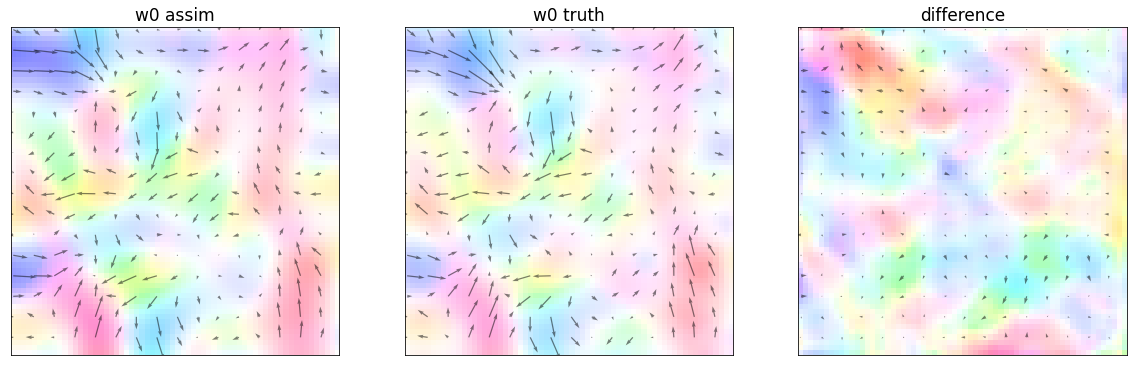

| Metric       |   Endpoint err. |   Angular err. (°) |   ||grad|| |   ||div|| |   ||lap|| |
|--------------+-----------------+--------------------+------------+-----------+-----------|
| 4D-Var       |       0.0335099 |             22.744 |    1.84128 |   1.64204 |  0.814327 |
| Ground truth |       0         |              0     |    1.66043 |   1.62583 |  0.554827 |


In [17]:
plt.figure(figsize=(20,10))

plot_w_compare(w0_truth, w0_deep,
               quiver=True,q_scale=3,normalization = True)

print_w_compare(w0_truth, w0_deep)

# Encapsulate the optimization in a class

In [10]:
assim=deeprior_strong_4DVar(generator=netG, dynamics=dynamics)

In [11]:
assim.fit(noise, Obs, Rm1)

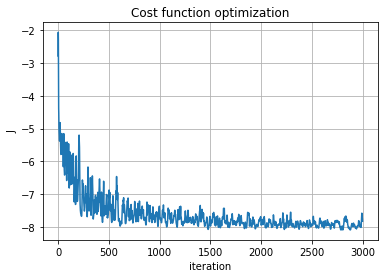

In [14]:
# plot
plt.plot(np.log(np.array(assim.losses)))
plt.grid()
plt.title('Cost function optimization')
plt.ylabel('J')
plt.xlabel('iteration')
plt.show()

In [12]:
ic_deep= assim.initial_condition
eta0_deep=ic_deep[0,:,:]
w0_4dvar_deep=ic_deep[1:,:,:]

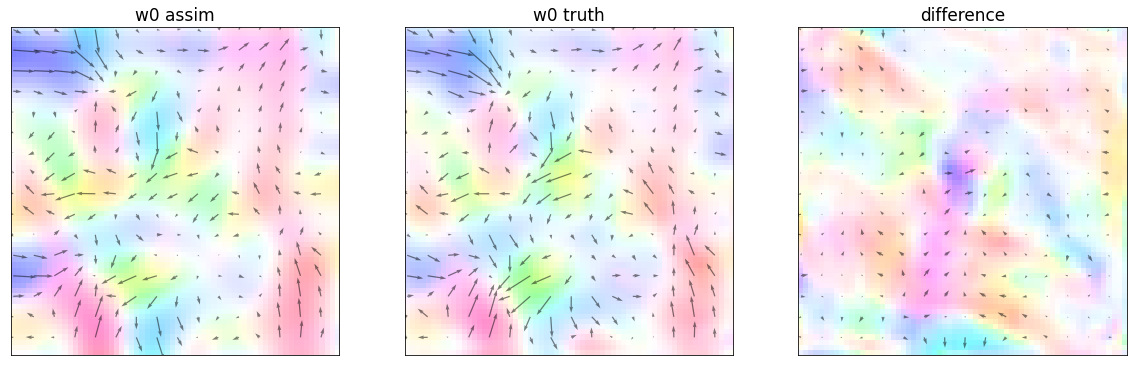

| Metric           |   Endpoint err. |   Angular err. (°) |   ||grad|| |   ||div|| |   ||lap|| |
|------------------+-----------------+--------------------+------------+-----------+-----------|
| Deep prior 4DVar |       0.0365595 |            20.1825 |    1.93689 |   1.66417 |  0.90748  |
| Ground truth     |       0         |             0      |    1.66043 |   1.62583 |  0.554827 |


In [17]:
plt.figure(figsize=(20,10))

plot_w_compare(w0_truth, w0_4dvar_deep,
               quiver=True,q_scale=3,normalization = True)

print_w_compare(w0_truth, w0_4dvar_deep,'Deep prior 4DVar')